In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage import io 
import matplotlib.pyplot as plt
import torch
import glob
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)
from sklearn.model_selection import train_test_split

path = "C:/Users/simon/OneDrive/Documents/munch project/"

In [5]:
# Personnalized functions

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [8]:
# Image size in pixel
IMAGE_SIZE = 256
# Number of color channels (3 for color, 1 for black and white)
CHANNELS = 3
BATCH_SIZE = 64
# Number of features in latent space
NUM_FEATURES = 128
# Latent space dimension
Z_DIM = 200

LEARNING_RATE = 0.0005
# Number of training periods
EPOCHS = 30
# Regularization parameter
BETA = 2000
# Option to load saved model
LOAD_MODEL = False

data_dir = "C:/Users/simon/OneDrive/Documents/munch project/"

In [9]:
# Load data using a library
images = utils.image_dataset_from_directory(
    path + "/munch_paintings",
    labels=None,                    # no label
    color_mode="rgb",               # rgb color
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE,           
    shuffle=True,                   # Shuffle data
    seed=42,
    interpolation="bilinear" 
)

Found 1745 files belonging to 1 classes.


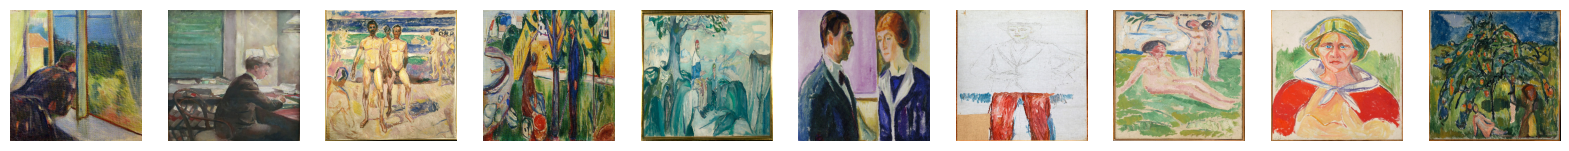

In [10]:
# Display of a batch to check import
# Sample batch from train data
train_sample = sample_batch(images)

# Display some paintings
display(train_sample, cmap=None)

# Preprocessing

In [11]:
# Scaling images to [-1,1] scale
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    img = (tf.cast(img, "float32") - 0.5) * 2
    return img

data = images.map(lambda x: preprocess(x))

## VAE

In [8]:
# Custom layer class for sampling in VAE (Variational Autoencoder)
class Sampling(layers.Layer):
    def call(self, inputs):
        # Extract means and log-variances
        z_mean, z_log_var = inputs

        # Get batch size and latent dimension
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Generate an epsilon sample from a normal distribution
        epsilon = K.random_normal(shape=(batch, dim))

        # Calculate the sample z using means, log-variances, and epsilon
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        return z


In [9]:
shape_before_flattening = data.element_spec.shape
print(shape_before_flattening)

(None, 256, 256, 3)


In [10]:
# Definition of the encoder model input
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Building convolution and normalization layers
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Adding additional convolution, normalization, and ReLU layers
# This allows learning features at different scales
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Flatten the activations into a vector
x = layers.Flatten()(x)

# Projection of activations into the latent space (z_mean and z_log_var)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

# Use the custom Sampling class for sampling
z = Sampling()([z_mean, z_log_var])

# Creation of the encoder model
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Display the summary of the encoder model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 128)        3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 128)        512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)        0         ['batch_normalization[0]

In [11]:
# Command to use to clear memory and liberate ram
tf.keras.backend.clear_session()

In [12]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

# Projection of latent activations into space before flattening
x = layers.Dense(256)(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Reshaping to the original shape before flattening
x = layers.Reshape((8,8,4))(x)

# Deconvolution layers to enlarge image
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Output layer to generate the decoded image
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)

# Creation of decoding model
decoder = models.Model(decoder_input, decoder_output)

# Display of the decoder summary
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       4736      
 anspose)                                                    

In [13]:
# Classe VAE (Variational Autoencoder)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # Initialisation de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder
        
        # Création de traqueurs pour les métriques
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Encoder and decoder call-up
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
    
        with tf.GradientTape() as tape:
            # Calculation of various loss indicators
            z_mean, z_log_var, reconstruction = self(data, training=True)
            
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            
            # Kullback-Leibler loss
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Calcul des gradients et mise à jour des poids
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Mise à jour des métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        
        # Calculation of various loss indicators
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        
        # Kullback-Leibler loss
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        
        # Total loss
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# Create VAE
vae = VAE(encoder, decoder)

In [15]:
# Compile VAE
optimizer = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
# Checkpoint creation to save model
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",  # Path to save weight of mdoels
    save_weights_only=False,  # Save complete model
    save_freq="epoch",  # Save at every end of period
    monitor="loss",
    mode="min",  # Minimise loss
    save_best_only=True,  # Save best model
    verbose=0,
)

# Create callback for logging
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Create callbacks class to generate images
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        
        # number of image to generate
        self.num_img = num_img
        # Latent dimensions
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("C:/Users/simon/OneDrive/Documents/munch project/generated_img_%03d_%d.png" % (epoch, i))

In [17]:
# Train VAE model on dataset
vae.fit(
    data,
    epochs=EPOCHS,  # Number of training periods
    callbacks=[  # List of callabcks to use during training
        model_checkpoint_callback,
        tensorboard_callback,  # logging for tensorboard
        ImageGenerator(num_img=10, latent_dim=Z_DIM),  # Generate image at the end of every period
    ],
)

Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 772.7837 - reconstruction_loss: 536.8304 - kl_loss: 57.7782 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1212s 40s/step - loss: 766.6397 - reconstruction_loss: 536.8304 - kl_loss: 57.7782
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 428.0169 - reconstruction_loss: 387.7856 - kl_loss: 30.6479 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1166s 40s/step - loss: 427.6864 - reconstruction_loss: 387.7856 - kl_loss: 30.6479
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 402.3051 - reconstruction_loss: 377.3150 - kl_loss: 26.0041 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1343s 48s/step - loss: 402.3400 - reconstruction_loss: 377.3150 - kl_loss: 26.0041
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 402.1950 - reconstruction_loss: 375.0478 - kl_loss: 26.6648 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1101s 38s/step - loss: 402.1784 - reconstruction_loss: 375.0478 - kl_loss: 26.6648
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 406.1180 - reconstruction_loss: 373.9685 - kl_loss: 27.1619 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1532s 55s/step - loss: 405.9460 - reconstruction_loss: 373.9685 - kl_loss: 27.1619
Epoch 6/30
28/28 [==============================] - ETA: 0s - loss: 395.4870 - reconstruction_loss: 369.0768 - kl_loss: 23.5795 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1227s 42s/step - loss: 395.3894 - reconstruction_loss: 369.0768 - kl_loss: 23.5795
Epoch 7/30
28/28 [==============================] - 1230s 40s/step - loss: 393.6906 - reconstruction_loss: 369.6523 - kl_loss: 23.3721
Epoch 8/30
28/28 [==============================] - 1428s 51s/step - loss: 394.4949 - reconstruction_loss: 369.0914 - kl_loss: 23.6960
Epoch 9/30
28/28 [==============================] - 1019s 35s/step - loss: 395.3024 - reconstruction_loss: 367.4204 - kl_loss: 25.4355
Epoch 10/30
28/28 [==============================] - 1181s 42s/step - loss: 392.0988 - reconstruction_loss: 369.6508 - kl_loss: 23.6601
Epoch 11/30
28/28 [==============================] - ETA: 0s - loss: 387.1064 - reconstruction_loss: 367.5912 - kl_loss: 22.3573 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1260s 45s/step - loss: 387.2044 - reconstruction_loss: 367.5912 - kl_loss: 22.3573
Epoch 12/30
28/28 [==============================] - 4787s 175s/step - loss: 391.3467 - reconstruction_loss: 367.8913 - kl_loss: 22.0804
Epoch 13/30
28/28 [==============================] - ETA: 0s - loss: 387.6000 - reconstruction_loss: 368.0986 - kl_loss: 21.7222 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1358s 47s/step - loss: 387.6766 - reconstruction_loss: 368.0986 - kl_loss: 21.7222
Epoch 14/30
28/28 [==============================] - ETA: 0s - loss: 386.2626 - reconstruction_loss: 367.0410 - kl_loss: 21.8934 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1334s 46s/step - loss: 386.3547 - reconstruction_loss: 367.0410 - kl_loss: 21.8934
Epoch 15/30
28/28 [==============================] - ETA: 0s - loss: 384.3309 - reconstruction_loss: 366.2993 - kl_loss: 22.1337 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1352s 46s/step - loss: 384.4723 - reconstruction_loss: 366.2993 - kl_loss: 22.1337
Epoch 16/30
28/28 [==============================] - ETA: 0s - loss: 389.4128 - reconstruction_loss: 364.9150 - kl_loss: 22.3695 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1264s 43s/step - loss: 389.3394 - reconstruction_loss: 364.9150 - kl_loss: 22.3695
Epoch 17/30
28/28 [==============================] - 1511s 53s/step - loss: 386.1526 - reconstruction_loss: 365.7689 - kl_loss: 22.8106
Epoch 18/30
28/28 [==============================] - 1107s 38s/step - loss: 385.3003 - reconstruction_loss: 368.5034 - kl_loss: 21.2628
Epoch 19/30
28/28 [==============================] - 1381s 49s/step - loss: 386.9848 - reconstruction_loss: 369.0163 - kl_loss: 20.6858
Epoch 20/30
28/28 [==============================] - ETA: 0s - loss: 388.9543 - reconstruction_loss: 364.3727 - kl_loss: 21.6316 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1336s 47s/step - loss: 388.8526 - reconstruction_loss: 364.3727 - kl_loss: 21.6316
Epoch 21/30
28/28 [==============================] - ETA: 0s - loss: 382.2156 - reconstruction_loss: 362.7525 - kl_loss: 20.3468 WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


28/28 [==============================] - 1318s 46s/step - loss: 382.2461 - reconstruction_loss: 362.7525 - kl_loss: 20.3468
Epoch 22/30
28/28 [==============================] - 994s 34s/step - loss: 384.1204 - reconstruction_loss: 362.7906 - kl_loss: 20.4047
Epoch 23/30
28/28 [==============================] - 1520s 54s/step - loss: 384.1151 - reconstruction_loss: 363.1891 - kl_loss: 20.1943
Epoch 24/30
28/28 [==============================] - 1233s 44s/step - loss: 384.7202 - reconstruction_loss: 363.6595 - kl_loss: 20.1032
Epoch 25/30
28/28 [==============================] - 1272s 45s/step - loss: 383.7039 - reconstruction_loss: 364.7466 - kl_loss: 21.3986
Epoch 26/30
28/28 [==============================] - 1232s 44s/step - loss: 380.7476 - reconstruction_loss: 364.9610 - kl_loss: 20.1802
Epoch 27/30
28/28 [==============================] - 1291s 46s/step - loss: 380.1670 - reconstruction_loss: 363.9929 - kl_loss: 20.7117
Epoch 28/30
28/28 [==============================] - 1184s 42

In [18]:
# Saved models
vae.save("./models/vae")  # Save VAE model
encoder.save("./models/encoder")  # Save encoder
decoder.save("./models/decoder")  # Save decoder

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


In [4]:
# Upload saved VAE model
vae = tf.keras.models.load_model('./models/vae')

## Creation of new paintings

In [28]:
# Select a sample in dataset
batches_to_predict = 1  # Number of batch to predict (batch size of 64)
example_images = np.array(
    # get_single_element extract one element
    list(data.take(batches_to_predict).get_single_element())
)

2/2 [==============================] - 11s 5s/step
Exemples de vrais tableaux


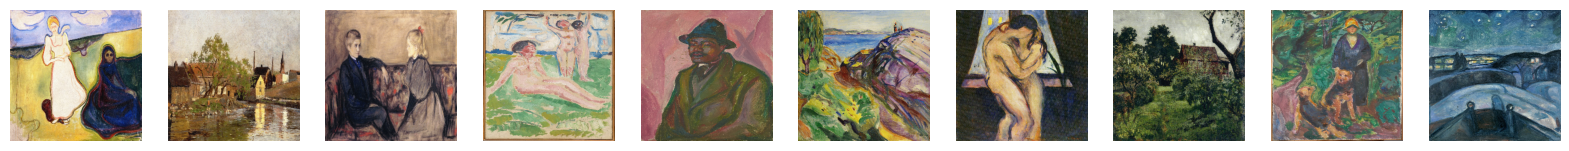

Reconstructions


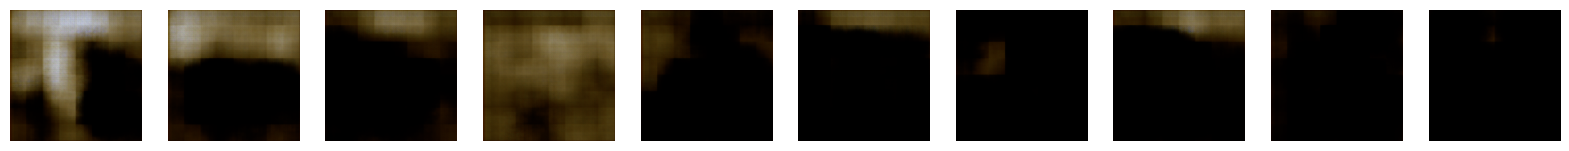

In [34]:
# Create predictions et display them
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Display true exemples
print("True images")
display(example_images)

# Display generate images
print("Reconstructions")
display(reconstructions)

The result may seem disappointing, but a much more complex model would be needed to obtain a correct result. The thing to remember is the method

## Modification of the news faces

In [46]:
# Load new images using a library
image_to_modify = utils.image_dataset_from_directory(
    path + "/image_to_modify",
    labels=None,                    # no label
    color_mode="rgb",               # rgb color
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=BATCH_SIZE,           
    shuffle=True,                   # Shuffle data
    seed=42,
    interpolation="bilinear" 
)

# Preprocess new data to the same foramt than the train data
test_images = image_to_modify.map(lambda x: preprocess(x))

Found 210 files belonging to 1 classes.


In [47]:
# Select a sample in dataset
batches_to_predict = 1  # Number of batch to predict (batch size of 64)
example_images = np.array(
    list(test_images.take(batches_to_predict).get_single_element())
)

2/2 [==============================] - 10s 5s/step
True images


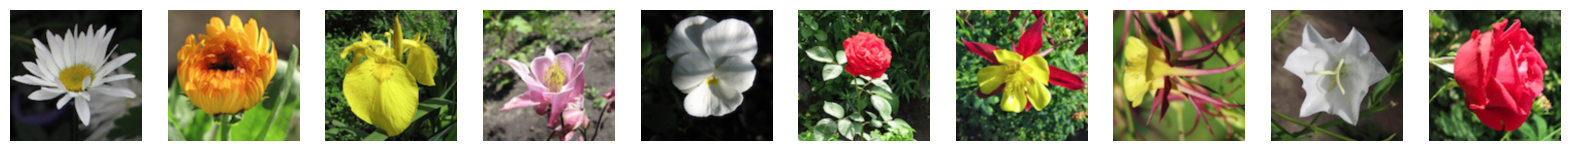

Reconstructions


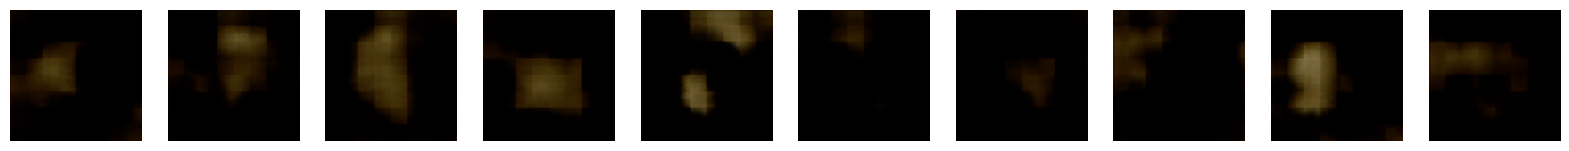

In [48]:
# Create predictions et display them
z_mean, z_log_var,reconstructions = vae.predict(example_images)

# Display true exemples
print("True images")
display(example_images)

# Display generate images
print("Reconstructions")
display(reconstructions)